In [3]:
%load_ext autoreload
%config Completer.use_jedi = False

In [4]:
%autoreload 2
import FEMOL
import numpy as np
np.set_printoptions(linewidth=200)
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, griddata
import matplotlib.cm as colormaps
import matplotlib.colors
from mpl_toolkits.axes_grid1 import Divider, Size
import meshio

# Development Notebook for the FEMOL Project

In [22]:
# Square mesh
mesh = FEMOL.mesh.rectangle_Q4(0.2, 0.2, 20, 20)
# laminates and materials
plies1 = [0, 0, 0]
plies2 = [90]
flax = FEMOL.materials.general_flax()
carbon = FEMOL.materials.general_carbon()
layup1 = FEMOL.laminate.Layup(material=flax, plies=plies1, symetric=True)
layup2 = FEMOL.laminate.Layup(material=carbon, plies=plies2, symetric=False, h_core=0, z_core= 0.005 + carbon.hi)
# FEM problem definition
problem = FEMOL.FEM_Problem(mesh=mesh, physics='modal', model='plate')
problem.define_materials(flax, carbon)
problem.define_tensors(layup1, layup2)  # thick=1
# First modal solve
w, v = problem.solve(filtre=0)


solving using scipy
solved in :  5.070746898651123  s


In [23]:
w[1]

238.57480314592092

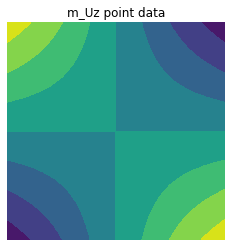

In [24]:
mesh.add_mode('m', v[1], 6)
mesh.wrap('m')
mesh.plot.point_data('m_Uz')
ref_vector = v[1]

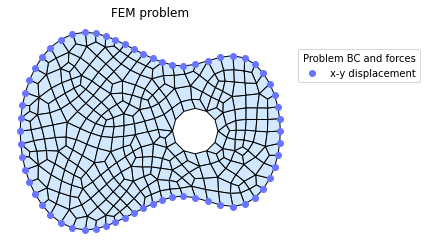

In [6]:
mesh = FEMOL.mesh.guitar()
problem = FEMOL.FEM_Problem(mesh=mesh, model='plane', physics='displacement')
problem.add_fixed_domain(FEMOL.domains.outside_guitar(L=1))
problem.plot()

solving using scipy
solved in :  3.9317808151245117  s


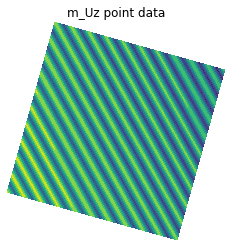

In [11]:
# Solve the eigenvalue problem for a 1x1 flax + carbon plate
# Square mesh
mesh = FEMOL.mesh.rectangle_Q4(0.2, 0.2, 20, 20)
# laminates and materials
plies1 = [0, 0, 0, 0, 0, 0]
plies2 = [90, 90]
flax = FEMOL.materials.general_flax()
carbon = FEMOL.materials.general_carbon()
layup1 = FEMOL.laminate.Layup(material=flax, plies=plies1, symetric=False)
layup2 = FEMOL.laminate.Layup(material=carbon, plies=plies2, symetric=False, h_core=0, z_core = 0.01 + carbon.hi)
# FEM problem definition
problem = FEMOL.FEM_Problem(mesh=mesh, physics='modal', model='plate')
problem.define_materials(flax, carbon)
problem.define_tensors(layup1, layup2)
# First modal solve
w, v = problem.solve(filtre=0)



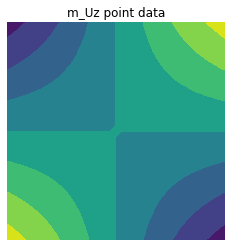

In [15]:
mesh.add_mode('m', v[4], 6)
mesh.wrap('m')
mesh.plot.point_data('m_Uz')
ref_vector = v[4]

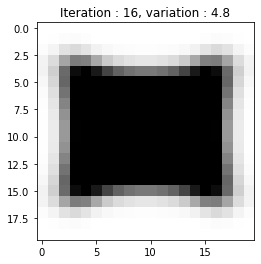

In [17]:
# Solve the eigenvalue maximization of the first mode
SIMP = FEMOL.SIMP_VIBE(Problem=problem, objective='max eig')
mesh = SIMP.solve(ref_vector, save=False, plot=True, converge=0.05)
mesh.save('TOM_modal_0_6_90_2_iter2')

In [27]:
SIMP.lmbd/238

1.7002668111913894

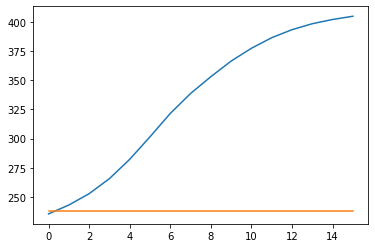

In [25]:
plt.plot(SIMP.lmbds)
plt.plot([0, 15], [238, 238])

In [636]:
mesh.cell_to_point_data('zc')

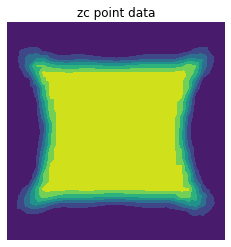

In [637]:
mesh.plot.point_data('zc')

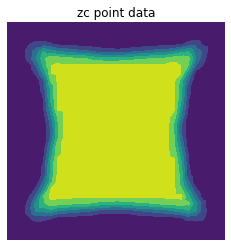

In [186]:
mesh = SIMP.density_to_core_height()
mesh.cell_to_point_data('zc')
mesh.plot.point_data('zc')

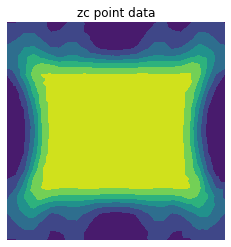

In [628]:
mesh2 = FEMOL.mesh.load_vtk('TOM_modal_90_90_mode0.vtk')
mesh2.cell_to_point_data('zc')
mesh2.plot.point_data('zc')

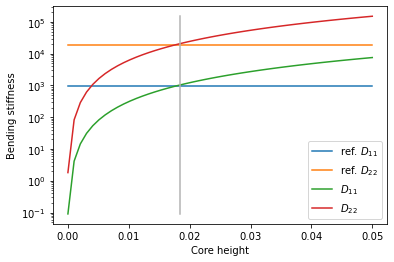

In [512]:
# Create a cutoff at the bending stiffness of the reference layup
# reference layup
plies_ref = [90]
carbon = FEMOL.materials.general_carbon()
layup_ref = FEMOL.laminate.Layup(material=carbon, plies=plies_ref, symetric=False, h_core=0, z_core = 0.025 + carbon.hi)
D_ref = layup_ref.D_mat

# Optimized layup
plies = [90, 90]
carbon = FEMOL.materials.general_carbon()
h = np.linspace(0, 0.05)
D_mats = []
for hi in h:
    layup = FEMOL.laminate.Layup(material=carbon, plies=plies, symetric=False, h_core=0, z_core = hi + carbon.hi)
    D_mats.append(layup.D_mat)
    
# Plot the two
plt.plot(h, [D_ref[0, 0]]*h.shape[0], label=r'ref. $D_{11}$')
plt.plot(h, [D_ref[1, 1]]*h.shape[0], label='ref. $D_{22}$')
D11 = [mat[0,0] for mat in D_mats]
plt.plot(h, D11, label = r'$D_{11}$')
D22 = [mat[1, 1] for mat in D_mats]
plt.plot(h, D22, label = r'$D_{22}$')
intersect = np.argwhere((D11 - D_ref[0, 0]) > 0)[0]
plt.plot([h[intersect]]*2, [min(D11), max(D22)], color='0.7')
plt.yscale('log')
plt.ylabel('Bending stiffness')
plt.xlabel('Core height')
plt.legend()
h_min = h[intersect][0]


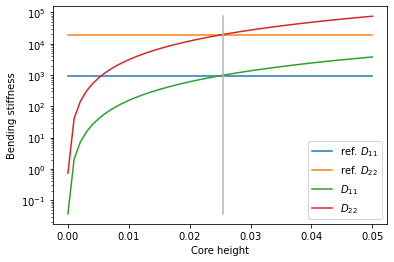

In [276]:
# Create a cutoff at the bending stiffness of the reference layup
# reference layup
plies_ref = [90]
carbon = FEMOL.materials.general_carbon()
D_mats_ref = []
h = np.linspace(0, 0.05)
for hi in h:
    layup_ref = FEMOL.laminate.Layup(material=carbon, plies=plies_ref, symetric=False, h_core=0, z_core = hi + carbon.hi)
    D_mats_ref.append(layup_ref.D_mat)

# Optimized layup
plies = [90, 90]
carbon = FEMOL.materials.general_carbon()
h = np.linspace(0, 0.05)
layup = FEMOL.laminate.Layup(material=carbon, plies=plies, symetric=False, h_core=0, z_core = h[-1] + carbon.hi)
D_mat = layup.D_mat
    
# Plot the two reference D at half density
plt.plot(h, [D_mat[0, 0]*(0.5**3)]*h.shape[0], label=r'ref. $D_{11}$')
plt.plot(h, [D_mat[1, 1]*(0.5**3)]*h.shape[0], label='ref. $D_{22}$')
# Plot the h dependend Di values
D11 = [mat[0,0] for mat in D_mats_ref]
plt.plot(h, D11, label = r'$D_{11}$')
D22 = [mat[1, 1] for mat in D_mats_ref]
plt.plot(h, D22, label = r'$D_{22}$')
intersect = np.argwhere((D11 - D_ref[0, 0]) > 0)[0]
plt.plot([h[intersect]]*2, [min(D11), max(D22)], color='0.7')
plt.yscale('log')
plt.ylabel('Bending stiffness')
plt.xlabel('Core height')
plt.legend()

In [580]:
# find the height corresponding to half the surface

def angle(point):
    return np.arctan2( point[0] - center[0], point[1] - center[1])

def distance(point):
    return np.sqrt((point[0] - center[0])**2 + (point[1] - center[1])**2)

def find_area(points, subdivision=20):
    # convert to numpy
    points = np.array(points)
    # Sort the points
    angles = [angle((xi, yi)) for xi, yi in points[:, :2]]
    pts_s = points.copy()[np.argsort(angles), :]
    angles = np.sort(angles)
    # radial integration divided in 100
    distances = []
    step = pts_s.shape[0]//subdivision
    i = 0
    while True:
        try:
            distances.append(np.max([distance(point) for point in pts_s[i:i+step]]))
            i += step
        except:
            break
    else:
        distances.append(np.max([distance(point) for point in pts_s[i:]]))

    area = 0
    T = (2*np.pi)/subdivision
    for i, _ in enumerate(distances[:-1]):
        hyp = min(distances[i], distances[i+1])
        b = max(distances[i], distances[i+1])
        h = hyp*np.sin(T)
        area += (b*h)/2

    return area

def height_with_area(mesh, target_area, precision=10e-3):
    h = 0
    h_max = mesh.point_data['zc'].max()
    increment = precision*h_max
    area = find_area(mesh.points)
    while area > target_area:
        h += increment
        points = mesh.points[mesh.point_data['zc']>h, :]
        area = find_area(points)
    return h

def heigh_from_mean_height(mesh, mean_height, precision=10e-3):
    h_vec = mesh.point_data['zc'].copy()
    increment = precision*h_vec.max()
    h = h_vec.min()
    while h_vec.mean() > mean_height:
        h += increment
        h_vec[h_vec<h] = h_vec.min()
    return h

def heigh_from_volume(mesh, target_volume, precision=10e-3):
    h = 0
    h_vec = mesh.point_data['zc'].copy()
    h_max = mesh.point_data['zc'].max()
    increment = precision*h_max
    volume = find_area(mesh.points) * h_vec.mean()
    while volume > target_volume:
        h += increment
        points = mesh.points[mesh.point_data['zc']>h, :]
        volume = find_area(points) * h_vec[h_vec>h].mean()
    return h

    

In [629]:
h_area = height_with_area(mesh2, 0.55)
h_height = heigh_from_mean_height(mesh, h_min)
h_volume = heigh_from_volume(mesh, 0.025)


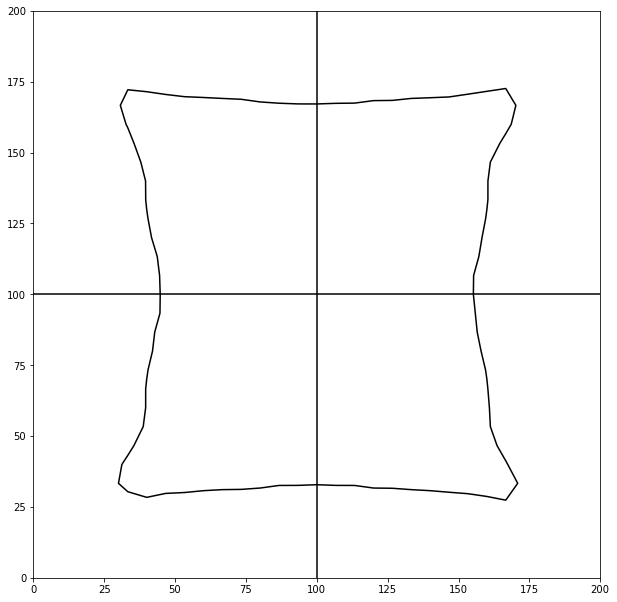

In [630]:
ax_in_size = 200/25.4
pad_in_size = (8.5 - ax_in_size)/2

fig = plt.figure(figsize=(8.5, 11))

# The first items are for padding and the second items are for the axes.
# sizes are in inch.
h = [Size.Fixed(pad_in_size), Size.Fixed(ax_in_size)]
v = [Size.Fixed(pad_in_size), Size.Fixed(ax_in_size)]

divider = Divider(fig, (0, 0, 1, 1), h, v, aspect=False)
# The width and height of the rectangle are ignored.

ax = fig.add_axes(divider.get_position(),
                  axes_locator=divider.new_locator(nx=1, ny=1))

Z = mesh.point_data['zc']
X = mesh.points[:, 0]*200
Y = mesh.points[:, 1]*200

colors=['k', 'r', 'b']

cs = ax.contour(X.reshape(31, 31), 
               Y.reshape(31, 31),
               Z.reshape(31, 31), 
               levels=[h_area],
               colors=colors)

plt.plot([100, 100], [0, 200], color='k')
plt.plot([0, 200], [100, 100], color='k')


#proxy = [plt.Rectangle((0,0),1,1,fc=c) for c in colors]

#plt.legend(proxy, ["Equivalent A"])
plt.show()

ax.set_aspect('equal')
fig.savefig('test.pdf')

In [600]:
# Mean stiffnesses
h_vec = mesh.point_data['zc'].copy()
h_vec[h_area > mesh.point_data['zc']] = h_vec.min()
h_bar = h_vec.mean()

# Optimized layup
plies = [90, 90]
carbon = FEMOL.materials.general_carbon()
layup = FEMOL.laminate.Layup(material=carbon, plies=plies, symetric=False, h_core=0, z_core = h_bar + carbon.hi)
D_mat_coat = layup.D_mat
A_mat_coat = layup.A_mat*0.5
flax = FEMOL.materials.general_flax()
layup2 = FEMOL.laminate.Layup(material=flax, plies=[0,0,0], symetric=True, h_core=0, z_core=0)
D_mat_base = layup2.D_mat
A_mat_base = layup2.A_mat

# reference layup
plies_ref = [90]
h_ref = 0.025
layup_ref1 = FEMOL.laminate.Layup(material=carbon, plies=plies_ref, symetric=False, h_core=0, z_core = h_ref + carbon.hi/2)
D_mat_ref_coat = layup_ref1.D_mat
A_mat_ref_coat = layup_ref1.A_mat




In [626]:
0.025 / 5

0.005

In [615]:
print('reference plate D : ')
D_mat_ref_coat + D_mat_base

reference plate : 


array([[  956.68356119,   265.53050828,    -0.        ],
       [  265.53050828, 18938.43322499,     0.        ],
       [   -0.        ,     0.        ,   332.5276875 ]])

In [616]:
print('Optimized plate D : ')
D_mat_coat + D_mat_base

Optimized plate : 


array([[ 1282.38960232,   356.7281998 ,    -0.        ],
       [  356.7281998 , 25452.55404751,     0.        ],
       [   -0.        ,     0.        ,   446.07793321]])

In [619]:
print('reference plate A : ')
(A_mat_ref_coat + A_mat_base) / 10e6

reference plate A : 


array([[ 3.79343011,  0.19516456, -0.        ],
       [ 0.19516456,  3.55823225,  0.        ],
       [-0.        ,  0.        ,  0.9525    ]])

In [621]:
print('optimized plate A : ')
(A_mat_coat + A_mat_base) / 10e6

optimized plate A : 


array([[ 3.79343011,  0.19516456, -0.        ],
       [ 0.19516456,  3.55823225,  0.        ],
       [-0.        ,  0.        ,  0.9525    ]])